# Предсказание температуры стали

**План проекта:**
        
1. Описание задачи 
2. Исследовательский анализ данных
3. Предобработка данных
4. Анализ и подготовка признаков
5. Обучение моделей
6. Итоговые выводы
7. Отчет

## 1 Описание задачи

**Задача:**  
  
Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали, чтобы оптимизировать производственные расходы. Задача построить модель, которая предскажет температуру стали. Показателями успешности модели будет метрика MAE. Дополнительная метрика R2. 

**Цель:**  
  
Достигнуть значения ключевой метрики MAE не выше 6.8 на тестовой выборке.
  
**Имеющиеся данные:**  
    
Данные состоят из файлов, полученных из разных источников:  
  
- `data_arc_new.csv` — данные об электродах
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём)
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время)
- `data_gas_new.csv` — данные о продувке сплава газом
- `data_temp_new.csv` — результаты измерения температуры
- `data_wire_new.csv` — данные о проволочных материалах (объём)
- `data_wire_time_new.csv` — данные о проволочных материалах (время)    
  
Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


## 2 Исследовательский анализ данных

In [1]:
# импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import catboost as cb
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor

import time

RANDOM_STATE = 220523

import warnings
warnings.filterwarnings('ignore')

In [2]:
# прочитаем датасеты

try:
    data_arc = pd.read_csv(
        '/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv(
        '/datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv(
        '/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv(
        '/datasets/data_gas_new.csv')
    data_temp = pd.read_csv(
        '/datasets/data_temp_new.csv')
    data_wire = pd.read_csv(
        'datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv(
        '/datasets/data_wire_time_new.csv')
        
except:
    data_arc = pd.read_csv(
        'https://code.s3.yandex.net//datasets/data_arc_new.csv')
    data_bulk = pd.read_csv(
        'https://code.s3.yandex.net//datasets/data_bulk_new.csv')
    data_bulk_time = pd.read_csv(
        'https://code.s3.yandex.net//datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv(
        'https://code.s3.yandex.net//datasets/data_gas_new.csv')
    data_temp = pd.read_csv(
        'https://code.s3.yandex.net//datasets/data_temp_new.csv')
    data_wire = pd.read_csv(
        'https://code.s3.yandex.net//datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv(
        'https://code.s3.yandex.net//datasets/data_wire_time_new.csv')

У нас 7 датасетов и не вся информация из них пригодится в проекте. Посмотрим, какие данные у нас имееются и в каком виде они находятся в таблицах.

### 2.1 Данные об электродах

In [3]:
# посмотрим датасет с данными об электродах data_arc

data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
# посмотрим датасет с данными об электродах data_arc

data_arc.tail()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


In [5]:
# посмотрим информацию о датасете data_arc

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
# посмотрим  описание датасета data_arc

data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [7]:
# посмотрим на количество ункальных ключей

len(data_arc['key'].unique())

3214

In [8]:
# проверим наличие явных дубликатов

data_arc.duplicated().sum()

0

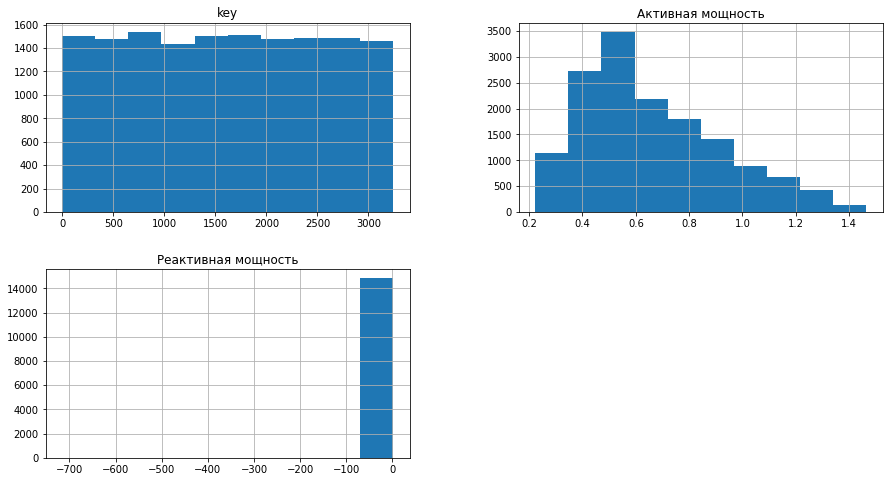

In [9]:
# посмотрим распределние значений на гистограммах

data_arc.hist(figsize=(15,8));

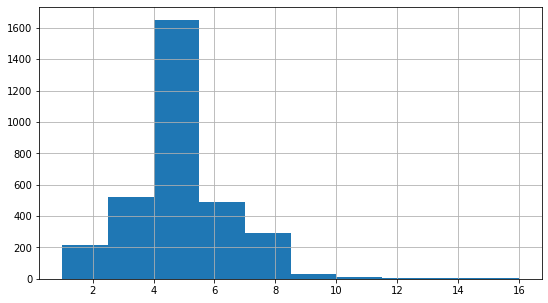

In [10]:
# посмотрим распределение количества нагревов по каждой партии

data_arc['key'].value_counts().hist(figsize=(9,5));

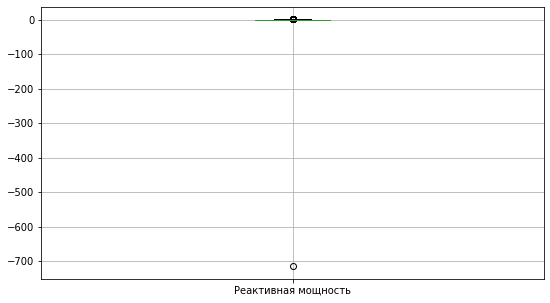

In [11]:
# посмотрим график ящик с усами для реактивной на предмет выбросов

data_arc.boxplot(column='Реактивная мощность', grid= True, figsize=(9,5));

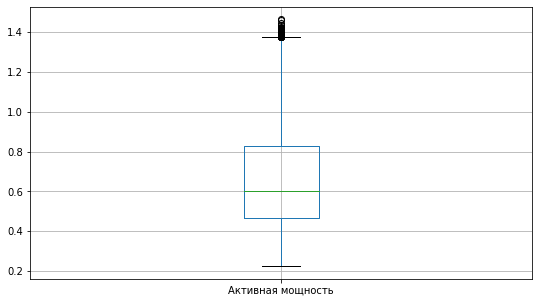

In [12]:
# посмотрим график ящик с усами для активной мощностей на предмет выбросов

data_arc.boxplot(column='Активная мощность', grid= True, figsize=(9,5));

**Вывод по данным об электродах:**  
   
- в датасете 5 столбцов и 14876 строк
- 3214 уникальных ключей - номеров партий
- нет явных дубликатов
- имеются выбросы: в столбце реактивной мощности одно отрицательное значение, в столбце активная мощность есть несколько значений выше 1.4
- количество нагревов варьируется от 1 до 16
- не верный тип данных у столбца начала и конца нагрева дугой
- наименования столбцов на русском и в верблюжьем регистре   
   
На этапе предобработке данных поправим тип данных, наименования столбцов и удалим строку с отрицательным значением в реактивной мощности.

### 2.2 Данные о подаче сыпучих материалов: объём и время

In [13]:
# посмотрим датасет с данными о подаче сыпучих материалов (объём) data_bulk

data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [14]:
# посмотрим датасет с данными о подаче сыпучих материалов (объём) data_bulk

data_bulk.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [15]:
# посмотрим информацию о датасете data_bulk

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [16]:
# посмотрим  описание датасета data_bulk

data_bulk.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [17]:
# посмотрим на количество ункальных ключей

len(data_bulk['key'].unique())

3129

In [18]:
# проверим наличие явных дубликатов

data_bulk.duplicated().sum()

0

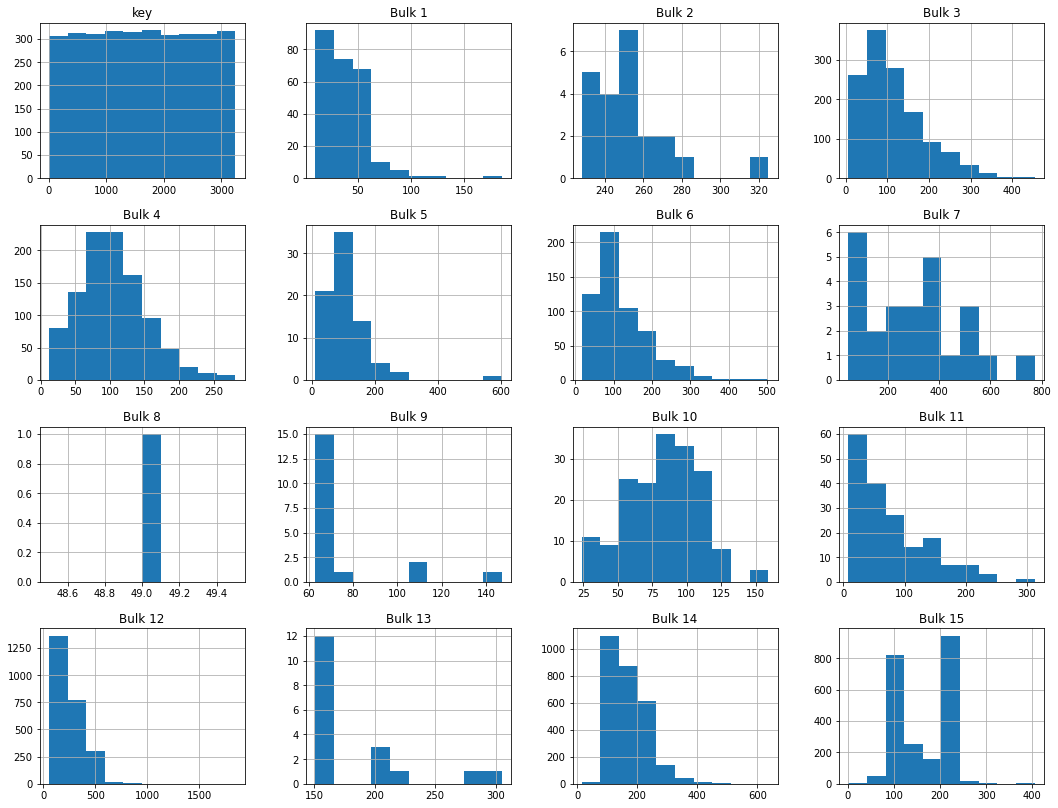

In [19]:
# посмотрим распределние значений на гистограммах

data_bulk.hist(figsize=(18,14));

**Вывод по данным об объеме подачи сыпучих материалов:**  
   
- в датасете 15 столбцов и 3129 строк - все они уникальные ключи (номера партий)
- нет явных дубликатов
- много пропусков - это специфика отрасли
- bulk 8 использовался только 1 раз - будем иметь ввиду при дальнейшей работе
- в большинсвте случаев распределение нормальное
  
На этапе предобработки данных нужно заполнить пропуска нулями, привести наименования столбцов к змеиному регистру

In [20]:
# посмотрим датасет с данными о подаче сыпучих материалов (время) data_bulk_time

data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [21]:
# посмотрим датасет с данными о подаче сыпучих материалов (время) data_bulk_time

data_bulk_time.tail()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3124,3237,NaN,NaN,2019-09-06 11:54:15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 11:49:45,NaN,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaN,NaN,2019-09-06 12:26:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 12:18:35,NaN,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:06:00,NaN,NaN,NaN,NaN,NaN,2019-09-06 15:01:44,NaN,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:24:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 16:07:29,2019-09-06 16:01:34
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-06 17:26:33,2019-09-06 17:23:15


In [22]:
# посмотрим информацию о датасете data_bulk_time

data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [23]:
# посмотрим описание датасета data_bulk_time

data_bulk_time.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [24]:
# посмотрим на количество ункальных ключей

len(data_bulk_time['key'].unique())

3129

In [25]:
# проверим наличие явных дубликатов

data_bulk_time.duplicated().sum()

0

**Вывод по данным о времени подачи сыпучих материалов:**  
   
- в датасете 15 столбцов и 3129 строк - все они уникальные ключи (номера партий) - как и в данных об объеме
- нет явных дубликатов
- много пропусков
  
Эти данные служат для нас проверкой верности данных в датасете об объеме подачи сыпучих материалов. Можно сказать, что все в порядке, так как количество столбцов и строк и ключей совпадает. 

### 2.3 Данные о продувке сплава газом

In [26]:
# посмотрим датасет с данными о продувке сплава газом data_gas

data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [27]:
# посмотрим датасет с данными о продувке сплава газом data_gas

data_gas.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [28]:
# посмотрим информацию о датасете data_gas

data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [29]:
# посмотрим  описание датасета data_gas

data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [30]:
# посмотрим на количество ункальных ключей

len(data_gas['key'].unique())

3239

In [31]:
# проверим наличие явных дубликатов

data_gas.duplicated().sum()

0

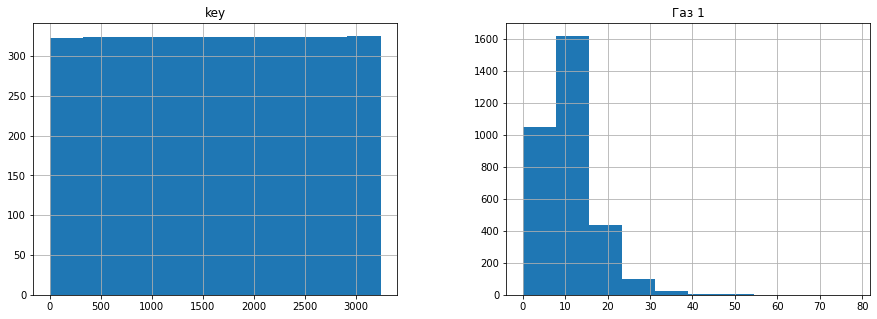

In [32]:
# посмотрим распределние значений на гистограммах

data_gas.hist(figsize=(15,5));

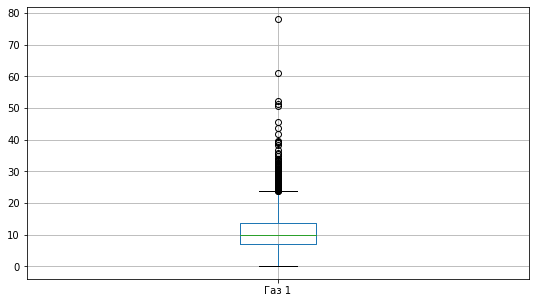

In [33]:
# посмотрим график ящик с усами для газа 1 на предмет выбросов

data_gas.boxplot(column='Газ 1', grid= True, figsize=(9,5));

**Вывод по данным о продувке сплава газом:**  
   
- в датасете 2 столбца и 3239 строк - все они уникальные ключи (номера партий)
- наименования столбца газ написано верблюжьим регистром и на русском языке
- нет явных дубликатов
- нет пропусков
- распределение нормальное, но есть выбросы
  
На этапе предобработки данных переименуем столбец. И будем иметь ввиду выбросы значений выше 40. 

### 2.4 Данные с результатами измерения температуры

In [34]:
# посмотрим датасет с данными с результатами измерения температуры data_temp

data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [35]:
# посмотрим датасет с данными с результатами измерения температуры data_temp

data_temp.tail()

,key,Время замера,Температура
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


In [36]:
# посмотрим информацию о датасете data_temp

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [37]:
# посмотрим  описание датасета data_temp

data_temp.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [38]:
# посмотрим на количество ункальных ключей

len(data_temp['key'].unique())

3216

In [39]:
# проверим наличие явных дубликатов

data_temp.duplicated().sum()

0

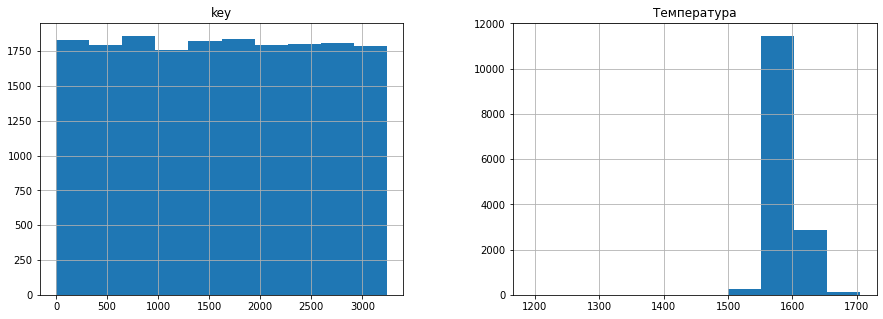

In [40]:
# посмотрим распределние значений на гистограммах

data_temp.hist(figsize=(15,5));

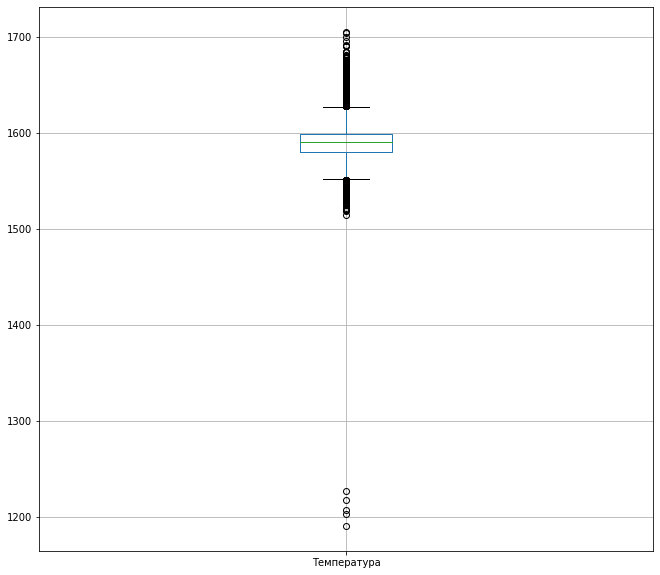

In [41]:
# посмотрим график ящик с усами для газа 1 на предмет выбросов

data_temp.boxplot(column='Температура', grid= True, figsize=(11,10));

По информации выше видно, что много пропусков и в хвосте отсутсвуют финальные замеры. Надо проверить более детально нулевые значения, чтобы сделать выводы.

In [42]:
# проверим количество нулевых значений замеров

data_temp['Температура'].isnull().sum()

3427

In [43]:
# выведем с какого значения начинаются нулевые измерения

data_temp[data_temp['Температура'].isnull()]

,key,Время замера,Температура
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [44]:
# выведем ключ 2500 и посмотрим все ли значения у него отсутсуют

data_temp[data_temp['key'] == 2500]

,key,Время замера,Температура
13926,2500,2019-08-10 14:04:39,1539.0
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN


**Вывод по данным о температуре:**  
   
- в датасете 2 столбца и 18092 строк
- 3216 уникальных ключа (номера партий)
- для каждой партии несколько замеров температуры - важные для нас первый и последний (target)
- наименования столбца температуры написано верблюжьим регистром и на русском языке
- нет явных дубликатов
- есть пропуски в данных
- с 2500 партии есть только первый замер температуры
- есть выбросы температуры ниже 1500 и выше 1650
  
На этапе предобработки данных переименуем столбец, удалим выбросы ниже 1500 градусов, посмотрим пристально на пропуски и решим по их обработке, а также удалим все партии с 2500, так как у них нет целевого замера - финальной температуры.

### 2.5 Данные о проволочных материалах: объём и время

In [45]:
# посмотрим датасет с данными о проволочных материалах (объём) data_wire

data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# посмотрим информацию о датасете data_wire

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [47]:
# посмотрим  описание датасета data_wire

data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [48]:
# посмотрим на количество ункальных ключей

len(data_wire['key'].unique())

3081

In [49]:
# проверим наличие явных дубликатов

data_wire.duplicated().sum()

0

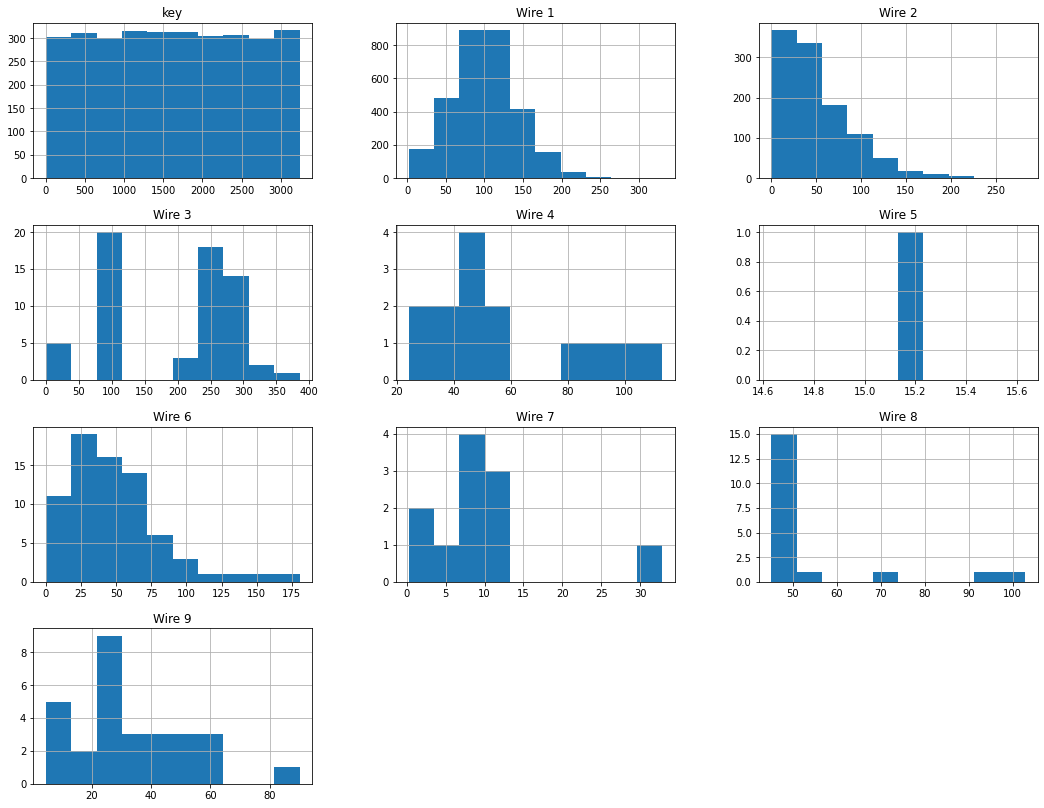

In [50]:
# посмотрим распределние значений на гистограммах

data_wire.hist(figsize=(18,14));

**Вывод по данным об объеме проволочных материалов:**  
   
- в датасете 10 столбцов и 3081 строк - все они уникальные ключи (номера партий)
- нет явных дубликатов
- много пропусков - это специфика отрасли
- wire 5 использовался только 1 раз - будем иметь ввиду при дальнейшей работе
- в большинсвте случаев распределение нормальное
  
На этапе предобработки данных нужно заполнить пропуски нулями, привести наименования столбцов к змеиному регистру.

In [51]:
# посмотрим датасет с данными о проволочных материалах (время) data_wire_time

data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# посмотрим информацию о датасете data_wire_time

data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [53]:
# посмотрим  описание датасета data_wire_time

data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [54]:
# посмотрим на количество ункальных ключей

len(data_wire_time['key'].unique())

3081

In [55]:
# проверим наличие явных дубликатов

data_wire_time.duplicated().sum()

0

**Вывод по данным о времени подачи проволочных материалов:**  
   
Эти данные служат для нас проверкой верности данных в датасете об объеме подачи проволочных материалов, как файл data_bulk_time служил для проверки даннных о сыпучих. Можно сказать, что все в порядке, так как количество столбцов 10 и строк 3081 и ключей 3081 совпадает. 

### 2.6 Вывод

Итак, после знакомства с данными мы знаем, что: 

- во всех датасетах разное количество уникальных ключей: data_arc 3214, data_bulk 3129, data_gas 3239, data_temp 3216, data_wire 3081
- датасеты data_bulk_time data_wire_time можно не использовать в дальнейшей работе
- есть неверные типы данных в data_arc
- много пропусков в data_bulk и data_wire
- наименования столбцов везде написаны верблюжьим регистром и русским языком
- нет явных дубликатов в данных
- bulk 8 и wire 5 использовались по 1 разу
- есть выбросы в данных о температуре, подаче газа и реактивной мощности
- нет замеров температуры кроме начальной у партий с 2500 номера

На предорбработке данных поправим наименования, заполним пропуски, удалим выброс в реактивной мощностиб а также удалим все партии с 2500, так как у них нет целевого замера - финальной температуры, и затем объединим данные в единую таблицу.   
  
Для объединения в таблицу нужно будет обработать значения в таблице data_temp, чтобы остались только начальная температура и конечная для каждого уникального ключа. А в таблице data_arc найти значение полной мощности и посмотреть при анализе признаков стоит ли оставить только его.   
  
Поскольку ключей у нас везде разное количество, то будем действовать по принципу внутреннего объединения исходя из наличия значений температуры нагрева. То есть присоединять будем к таблице data_temp.

## 3 Предобработка данных

Сначала обработаем данные для каждого датасета, а затем объединим их в единую таблицу.

### 3.1 Данные об электродах

In [56]:
# удалим значения key начиная с 2500 партии

data_arc = data_arc[data_arc['key']<2500]

In [57]:
# переименуем столбцы

data_arc.columns = ['key', 'start_heat', 'end_heat', 'active_power', 'reactive_power']

In [58]:
# проверим преобразобвания

data_arc.tail()

,key,start_heat,end_heat,active_power,reactive_power
11444,2498,2019-08-10 13:20:18,2019-08-10 13:20:59,0.508786,0.363916
11445,2499,2019-08-10 13:33:31,2019-08-10 13:38:43,0.700677,0.534767
11446,2499,2019-08-10 13:41:44,2019-08-10 13:45:09,0.333776,0.269695
11447,2499,2019-08-10 13:46:38,2019-08-10 13:51:33,0.406252,0.263303
11448,2499,2019-08-10 13:55:06,2019-08-10 13:56:17,0.296379,0.229071


In [59]:
# приведем начало и конец нагрева к типу данных datetime

data_arc[['start_heat', 'end_heat']] = data_arc[['start_heat', 'end_heat']].apply(pd.to_datetime)

In [60]:
# проверим типы данных

data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11449 entries, 0 to 11448
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             11449 non-null  int64         
 1   start_heat      11449 non-null  datetime64[ns]
 2   end_heat        11449 non-null  datetime64[ns]
 3   active_power    11449 non-null  float64       
 4   reactive_power  11449 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 536.7 KB


In [61]:
# удалим отрицательное значение реактивной мощности - выброс

data_arc = data_arc[data_arc['reactive_power']>0]

In [62]:
# проверим изменение

data_arc.describe()

,key,active_power,reactive_power
count,11448.000000,11448.000000,11448.000000
mean,1242.061233,0.665347,0.489740
std,718.930527,0.260229,0.198992
min,1.000000,0.223895,0.153777
25%,623.000000,0.468179,0.339256
50%,1245.000000,0.601417,0.442781
75%,1870.000000,0.833455,0.611949
max,2499.000000,1.463773,1.270284


Мы исправили все ошибки и теперь посчитаем:  
  
- продолжительность нагрева - разница конца и начала времени нагрева
- полную мощность - квадратный корень из суммы квадратов активной и реактивной мощностей


In [63]:
# найдем продолжительность нагрева

data_arc['heating_time'] = data_arc['end_heat'] - data_arc['start_heat']
data_arc['heating_time'] = data_arc['heating_time'].dt.seconds

In [64]:
# посчитаем полную мощность

data_arc['full_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

In [65]:
# проверим добавились ли расчеты в таблицу

data_arc.head()

,key,start_heat,end_heat,active_power,reactive_power,heating_time,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148,1.079934


Поскольку замеры у нас имеются для каждого ключа несколько раз, то нам нужно сделать таблицу, где для каждого ключа будут суммарные исчисления. При этом можно убрать столюцы с началом и концом нагрева дугой.

In [66]:
# сгруппируем данные по key и агрегируем их по суммам

data_arc_sum = data_arc.groupby('key').agg(heating_time = ('heating_time', 'sum'), 
                                           active_power = ('active_power', 'sum'),
                                           reactive_power = ('reactive_power', 'sum'),
                                           full_power = ('full_power', 'sum'))

In [67]:
# посмотрим на получившуюся таблицу

data_arc_sum.head(10)

,heating_time,active_power,reactive_power,full_power
key,,,,
1,1098,3.036730,2.142821,3.718736
2,811,2.139408,1.453357,2.588349
3,655,4.063641,2.937457,5.019223
4,741,2.706489,2.056992,3.400038
5,869,2.252950,1.687991,2.816980
6,952,2.725274,1.881313,3.313074
7,673,2.626877,1.960419,3.283913
8,913,2.678958,2.096952,3.405956
9,625,3.520820,2.527365,4.335261


**Вывод:**  
  
Мы исправили наименования столбцов, удалили выброс, убрали данные для партий с 2500, так как в них не было замеров, и сформировали новый датасет с информацией о длительности нагрева, активной и реактивной мощностях, полной мощности.

### 3.2 Данные о подаче сыпучих материалов

In [68]:
# удалим значения key начиная с 2500 партии

data_bulk = data_bulk[data_bulk['key']<2500]

In [69]:
# переименуем столбцы

data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 
                     'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 
                     'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [70]:
# заполним пропуски нулями в соответсвии с указаниями заказчика

data_bulk.fillna(0, inplace=True)

In [71]:
# проверим преобразования

data_bulk.tail()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2403,2495,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0
2404,2496,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0
2405,2497,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0
2406,2498,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0
2407,2499,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0


In [72]:
# проверим остались ли пропуски

data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 0 to 2407
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      2408 non-null   int64  
 1   bulk_1   2408 non-null   float64
 2   bulk_2   2408 non-null   float64
 3   bulk_3   2408 non-null   float64
 4   bulk_4   2408 non-null   float64
 5   bulk_5   2408 non-null   float64
 6   bulk_6   2408 non-null   float64
 7   bulk_7   2408 non-null   float64
 8   bulk_8   2408 non-null   float64
 9   bulk_9   2408 non-null   float64
 10  bulk_10  2408 non-null   float64
 11  bulk_11  2408 non-null   float64
 12  bulk_12  2408 non-null   float64
 13  bulk_13  2408 non-null   float64
 14  bulk_14  2408 non-null   float64
 15  bulk_15  2408 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 319.8 KB


Мы удалили данные о партиях начиная с 2500, переименовали столбцы и заполнили пропуски нулями.

### 3.3 Данные о продувке сплава газом

In [73]:
# удалим значения key начиная с 2500 партии

data_gas = data_gas[data_gas['key']<2500]

In [74]:
# переименуем столбцы

data_gas.columns = ['key', 'gas_1']

In [75]:
# проверим изменения

data_gas.tail()

,key,gas_1
2492,2495,7.125735
2493,2496,9.412616
2494,2497,6.271699
2495,2498,14.953657
2496,2499,11.336151


**Вывод:**     
  
Мы переименовали столбец с информацией о газе, удалили партии с 2500.

### 3.4 Данные с результатами измерения температуры

In [76]:
# удалим значения key начиная с 2500 партии

data_temp = data_temp[data_temp['key']<2500]

In [77]:
# переименуем столбцы

data_temp.columns = ['key', 'measurement_time', 'temperature']

In [78]:
# проверим датасет

data_temp.tail()

,key,measurement_time,temperature
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0
13925,2499,2019-08-10 13:58:58,1603.0


In [79]:
# приведем начало и конец нагрева к типу данных datetime

data_temp['measurement_time'] = data_temp['measurement_time'].apply(pd.to_datetime)

In [80]:
# проверим типы данных

data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               13926 non-null  int64         
 1   measurement_time  13926 non-null  datetime64[ns]
 2   temperature       13926 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.2 KB


In [81]:
# оставим в таблице только первый и последний замер для каждого ключа

data_temp_edges = data_temp.groupby(by = 'key', as_index = False).agg(['first', 'last'])

In [82]:
# проверим получившуюся таблицу

data_temp_edges.head()

measurement_time                     temperature        
                  first                last       first    last
key                                                            
1   2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0  1613.0
2   2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0  1602.0
3   2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0  1599.0
4   2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0  1625.0
5   2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0  1602.0

In [83]:
# переименуем столбцы, чтобы избавиться от второй линии в названиях 

data_temp_edges.columns = ['time_first', 'time_last', 'temp_first', 'temp_last']

In [84]:
# проверим получившуюся таблицу

data_temp_edges.head()

,time_first,time_last,temp_first,temp_last
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [85]:
# посмотрим остались ли выбросы в сведенных данных

data_temp_edges.describe()

,temp_first,temp_last
count,2477.000000,2477.000000
mean,1588.405733,1595.334275
std,29.232904,16.019339
min,1191.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1605.000000,1599.000000
max,1679.000000,1700.000000


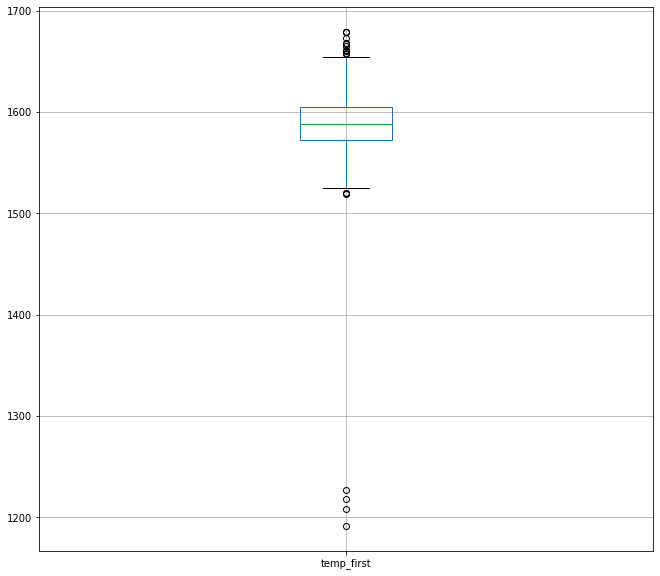

In [86]:
# посмотрим график ящик с усами для начальных замеров на предмет выбросов

data_temp_edges.boxplot(column='temp_first', grid= True, figsize=(11,10));

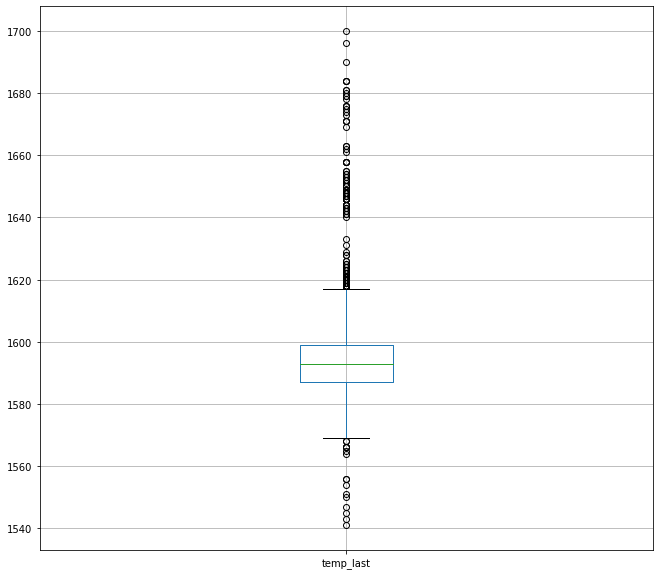

In [87]:
# посмотрим график ящик с усами для конечных замеров на предмет выбросов

data_temp_edges.boxplot(column='temp_last', grid= True, figsize=(11,10));

Выбросы есть в минамальных замерах меньше 1500 градусов, по условию такие партии можно удалить, так как при этой температура металл не плавится. 

In [88]:
# удалим выбросы в замерах меньше 1500 градусов

data_temp_edges = data_temp_edges[data_temp_edges['temp_first']>1500]

In [89]:
# посмотрим на данные после удаления выбросов

data_temp_edges.describe()

,temp_first,temp_last
count,2473.000000,2473.000000
mean,1589.016175,1595.338051
std,24.996127,16.031388
min,1519.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1605.000000,1599.000000
max,1679.000000,1700.000000


**Вывод:**  
  
Мы удалили все партии с 2500, оставили только первые и последние замеры темературы, избавились от выбросов.  Данные с измерением температуры готовы. 

### 3.5 Данные о проволочных материалах

In [90]:
# удалим значения key начиная с 2500 партии

data_wire = data_wire[data_wire['key']<2500]

In [91]:
# переименуем столбцы

data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 
                     'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [92]:
# заполним пропуски нулями в соответсвии с указаниями заказчика

data_wire.fillna(0, inplace=True)

In [93]:
# проверим преобразования

data_wire.tail()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2368,2495,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2369,2496,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2370,2497,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2371,2498,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2372,2499,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# проверим остались ли пропуски

data_wire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2373 entries, 0 to 2372
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     2373 non-null   int64  
 1   wire_1  2373 non-null   float64
 2   wire_2  2373 non-null   float64
 3   wire_3  2373 non-null   float64
 4   wire_4  2373 non-null   float64
 5   wire_5  2373 non-null   float64
 6   wire_6  2373 non-null   float64
 7   wire_7  2373 non-null   float64
 8   wire_8  2373 non-null   float64
 9   wire_9  2373 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 203.9 KB


**Вывод:**  
  
Мы удалили информацию о партиях с 2500, заполнили пропуски нулями и привели наименования столбцов к змеиному регистру.

### 3.6 Объединение таблиц

Данные во всех датасетах готовы и теперь их можно объединить в одну таблицу для дальнейшей работы с признаками. Объединять будем по принципу внутреннего объединения и присоединение будет к таблицу о замерах температуру по номерам партий.

In [95]:
# для таблиц о замерах температура и эдектродах key с индекса на столбец для удобства объединения

data_arc_sum = data_arc_sum.rename_axis('key').reset_index()
data_temp_edges = data_temp_edges.rename_axis('key').reset_index()

In [96]:
# проверим результат

data_arc_sum.head()

,key,heating_time,active_power,reactive_power,full_power
0,1,1098,3.036730,2.142821,3.718736
1,2,811,2.139408,1.453357,2.588349
2,3,655,4.063641,2.937457,5.019223
3,4,741,2.706489,2.056992,3.400038
4,5,869,2.252950,1.687991,2.816980


In [97]:
# проверим результат

data_temp_edges.head()

,key,time_first,time_last,temp_first,temp_last
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0


In [98]:
# присоединяем к датасету о температурных замерах данные об электродах

data = data_temp_edges.merge(data_arc_sum, on='key', how='inner')
data = data.merge(data_bulk, on='key', how='inner')
data = data.merge(data_gas, on='key', how='inner')
data = data.merge(data_wire, on='key', how='inner')

In [99]:
# посмотрим на получившуюся таблицу

data.head()

,key,time_first,time_last,temp_first,temp_last,heating_time,active_power,reactive_power,full_power,bulk_1,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1098,3.036730,2.142821,3.718736,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,811,2.139408,1.453357,2.588349,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,655,4.063641,2.937457,5.019223,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,741,2.706489,2.056992,3.400038,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,869,2.252950,1.687991,2.816980,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# посмотрим на размеры

data.shape

(2325, 34)

In [101]:
# посомтрим на данные и описание

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 34 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             2325 non-null   int64         
 1   time_first      2325 non-null   datetime64[ns]
 2   time_last       2325 non-null   datetime64[ns]
 3   temp_first      2325 non-null   float64       
 4   temp_last       2325 non-null   float64       
 5   heating_time    2325 non-null   int64         
 6   active_power    2325 non-null   float64       
 7   reactive_power  2325 non-null   float64       
 8   full_power      2325 non-null   float64       
 9   bulk_1          2325 non-null   float64       
 10  bulk_2          2325 non-null   float64       
 11  bulk_3          2325 non-null   float64       
 12  bulk_4          2325 non-null   float64       
 13  bulk_5          2325 non-null   float64       
 14  bulk_6          2325 non-null   float64       
 15  bulk

**Вывод:**  
  
Общая таблица готова. У нас 34 столбца и 2325 строк. Наименования и типы данных верные. Пропусков нет. Лишние данные удалены. 

### 3.7 Вывод

На этом этапе мы обработали данные всех имеющихся таблиц:  
  
- в data_arc: исправили наименования столбцов, удалили отрицательное значение (выброс) в реактивной мощности, убрали данные для партий с 2500, так как в них не было замеров, сформировали новый датасет с информацией о длительности нагрева, активной и реактивной мощностях, полной мощности
- в data_bulk: удалили данные о партиях начиная с 2500, переименовали столбцы и заполнили пропуски нулями
- в data_gas: переименовали столбец с информацией о газе, удалили партии с 2500
- в data_temp: удалили все партии с 2500, оставили только первые и последние замеры темературы, избавились от выбросов
- в data_wire: удалили информацию о партиях с 2500, заполнили пропуски нулями и привели наименования столбцов к змеиному регистру  
   
После подготовки данных мы объединили их в единую таблицу для дальнейшей работы с признаками. Переходим к анализу признаков и подготовке выборок для обучения моделей.

## 4 Анализ и подготовка признаков

На этом шага будет работать с признаками: посмотрим распределние признаков на гистограмме, проверим корреляцию, удалим не коррелериющие признаки и поделим датасет на признаки и целевой признак, а так же отделим обучающую и тестовую выборки.

### 4.1 Анализ распределения и корреляции признаков

In [102]:
# посмотрим на сводную таблицу

data.head()

,key,time_first,time_last,temp_first,temp_last,heating_time,active_power,reactive_power,full_power,bulk_1,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1098,3.036730,2.142821,3.718736,0.0,...,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,811,2.139408,1.453357,2.588349,0.0,...,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,655,4.063641,2.937457,5.019223,0.0,...,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,741,2.706489,2.056992,3.400038,0.0,...,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,869,2.252950,1.687991,2.816980,0.0,...,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


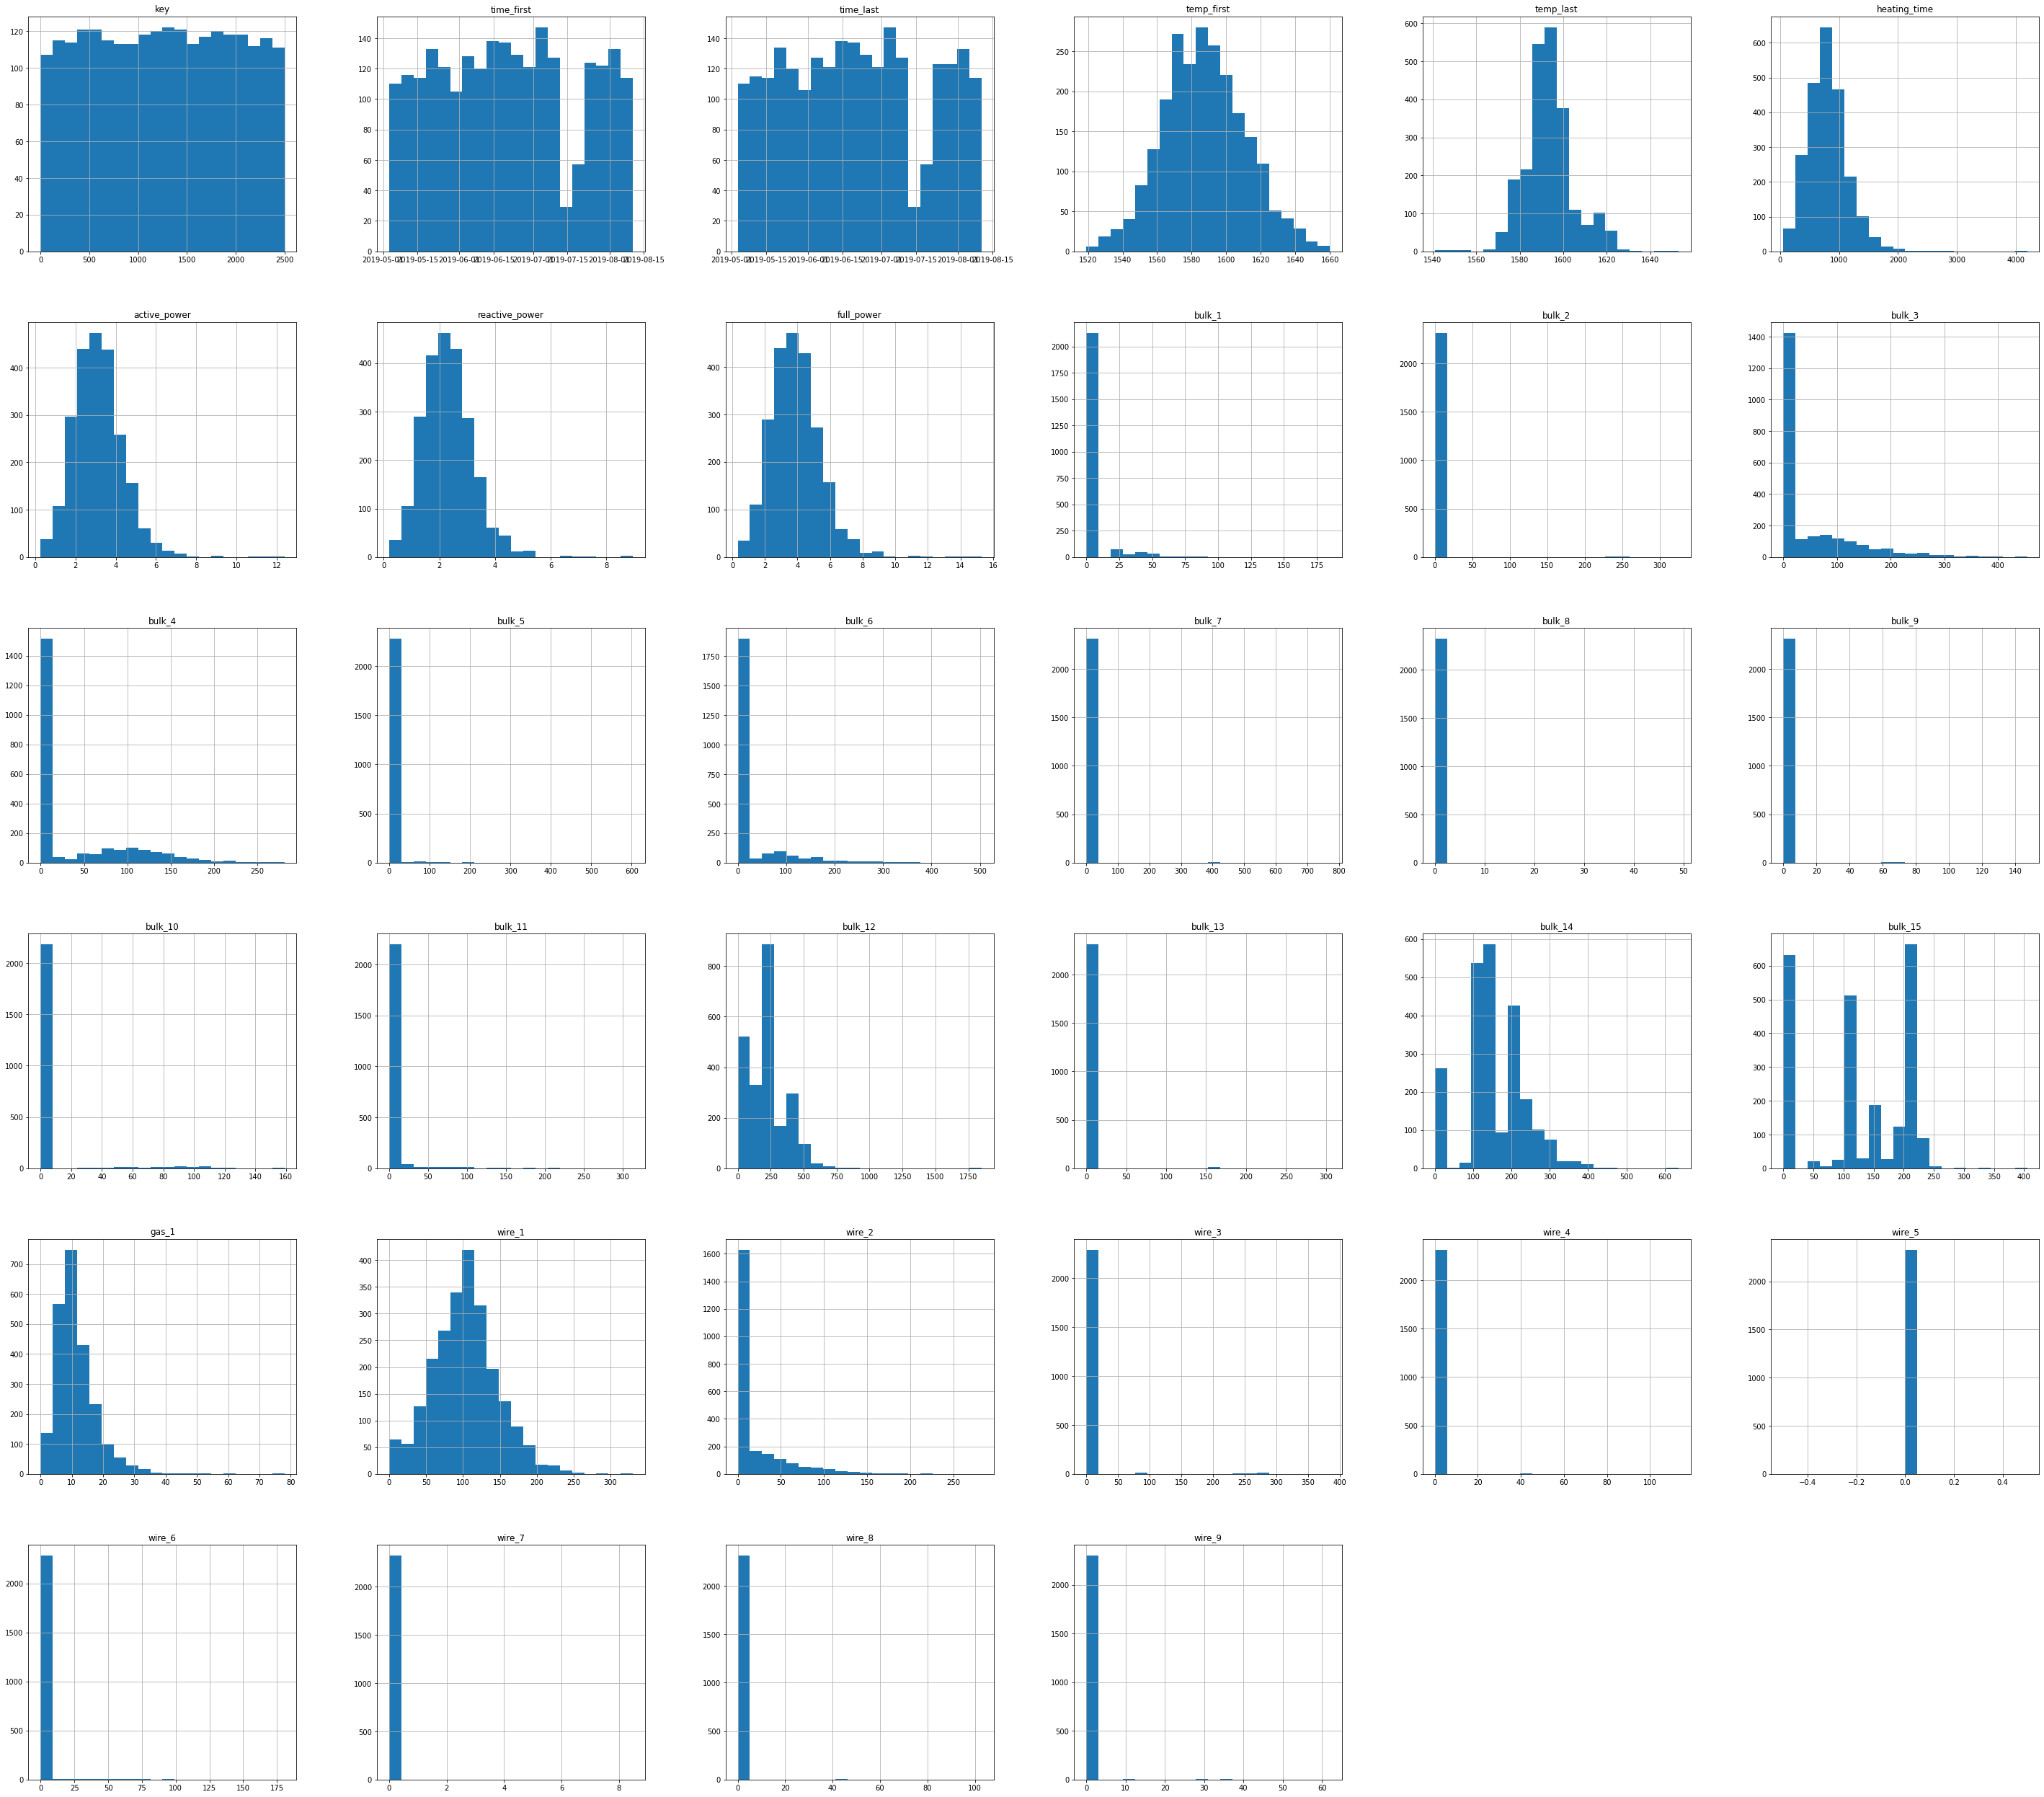

In [103]:
# посмотрим распределние значений на гистограммах

data.hist(figsize=(50,45), bins=20);

По графикам видно, что в болбьшинстве случаев распределние нормальное, но так же есть сыпучие смеси и проволочные материалы, которые добавлялись один или малое количество раз. Посмотрим, как они коррелируют с другими признаками и с целевым признаком.

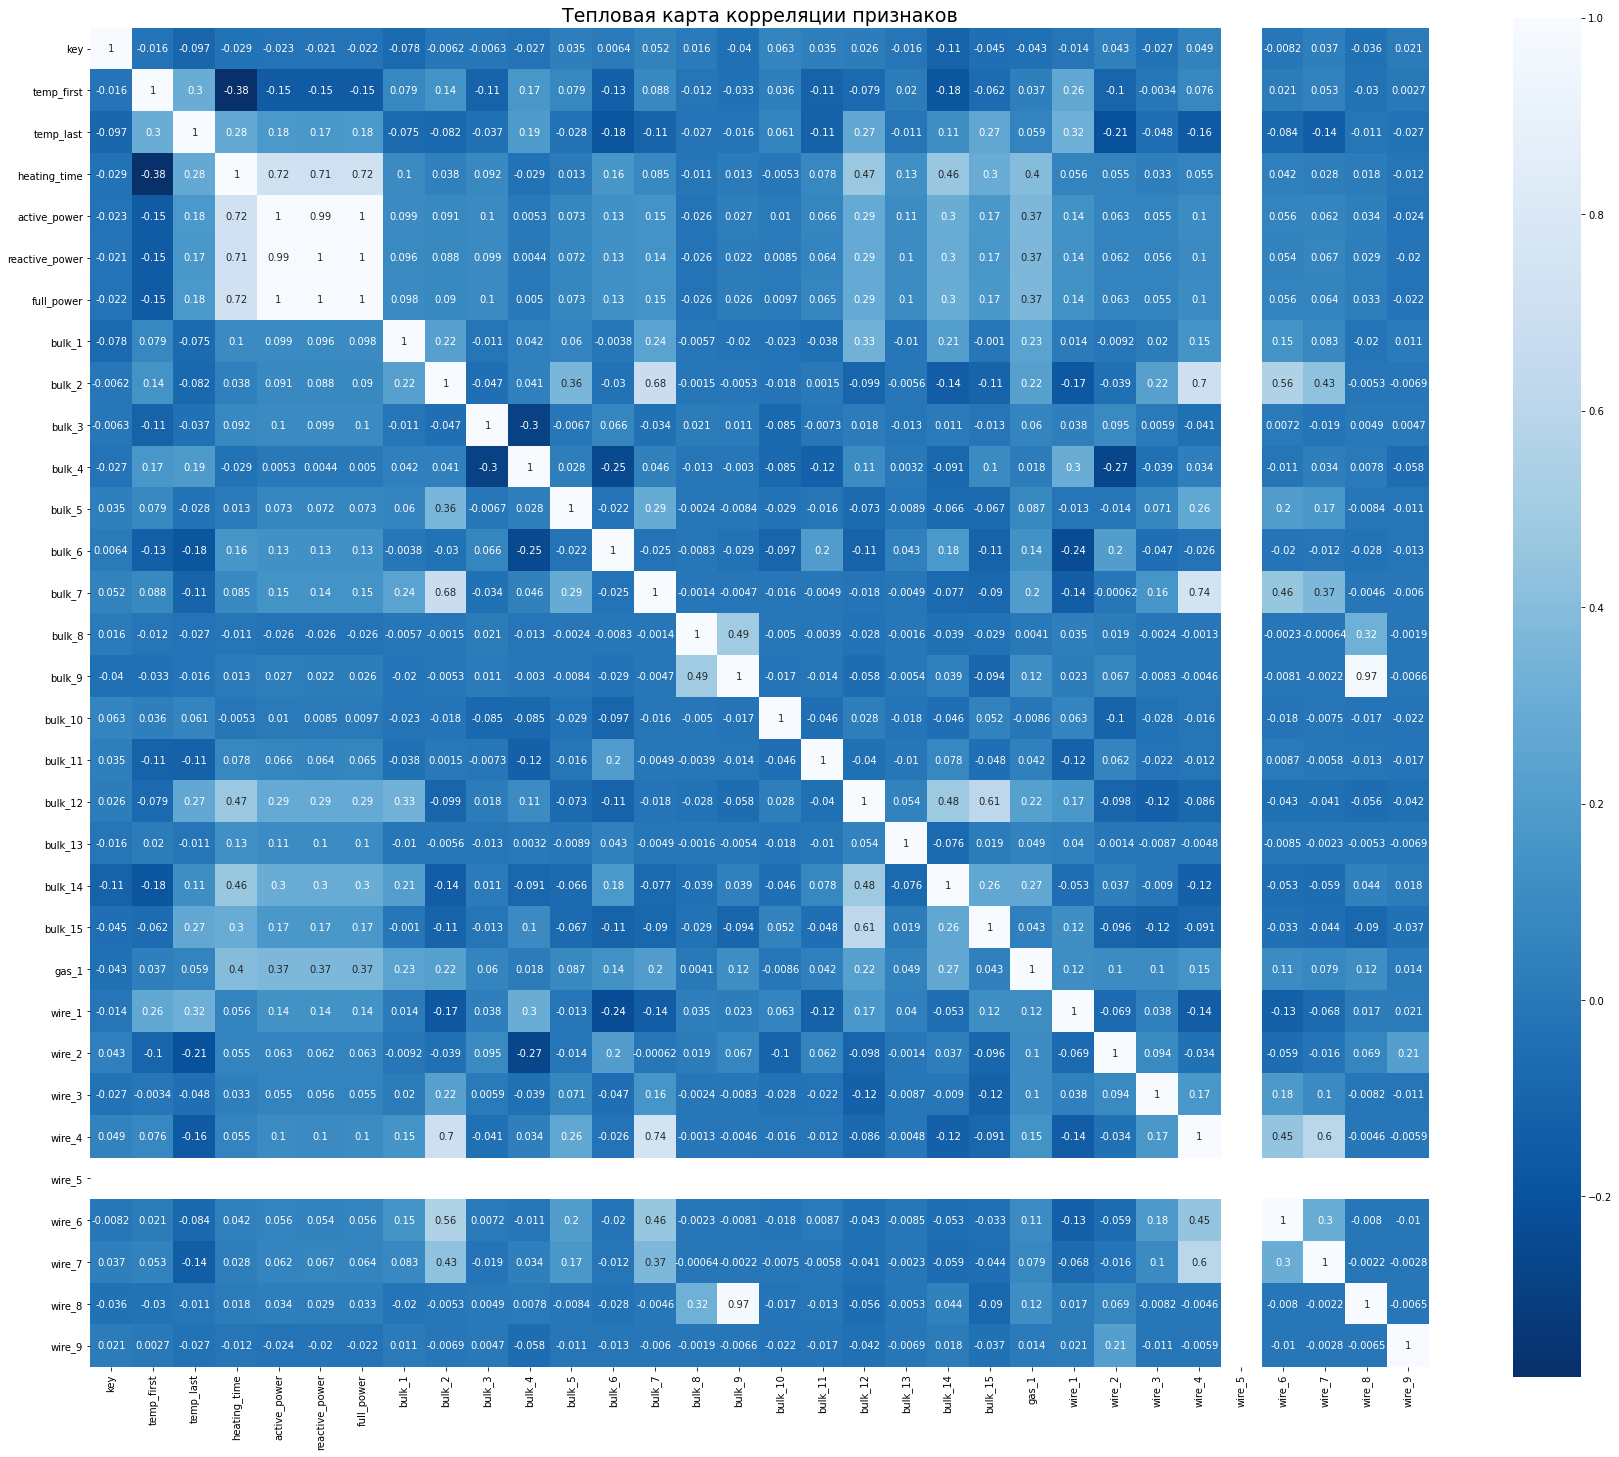

In [104]:
# посмотрим тепловую карту корреляций признаков 

f, ax = plt.subplots(figsize=(30, 25))

corr = data.corr()
heatmap = sns.heatmap(corr,
                      xticklabels=True, 
                      yticklabels=True, 
                      annot=True, 
                      cmap='Blues_r', 
                      square=True);
plt.title('Тепловая карта корреляции признаков', fontsize=19)
plt.show();

Из тепловой карты корреляции видим, что:  
  
- wire_5 полностью пустой, нет корреляции ни с чем, этот признак можно удалить
- у целевого признака temp_last нет сильной корреляции с другими признаками, с некоторыми даже есть отрицательная
- между признаками активной и реактивной мощности и полной мощность большая корреляция из-за того, как вычисляется мощность, поэтому стоит оставить только full_power
- на тепловой карте  время первого и последнего замера не обозначились, но они так же не имеют сильного значения и их можно удалить
  
Удалим лишние признаки и построем таблицу корреляции с целевым признаком для оставшихся


In [105]:
# удалим лишние признаки

data = data.drop(['key', 'active_power', 'reactive_power', 
                  'wire_5', 'time_first', 
                  'time_last'], axis = 1)

In [106]:
# проверим результат

data.head()

,temp_first,temp_last,heating_time,full_power,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1571.0,1613.0,1098,3.718736,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,811,2.588349,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,655,5.019223,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,741,3.400038,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,869,2.816980,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


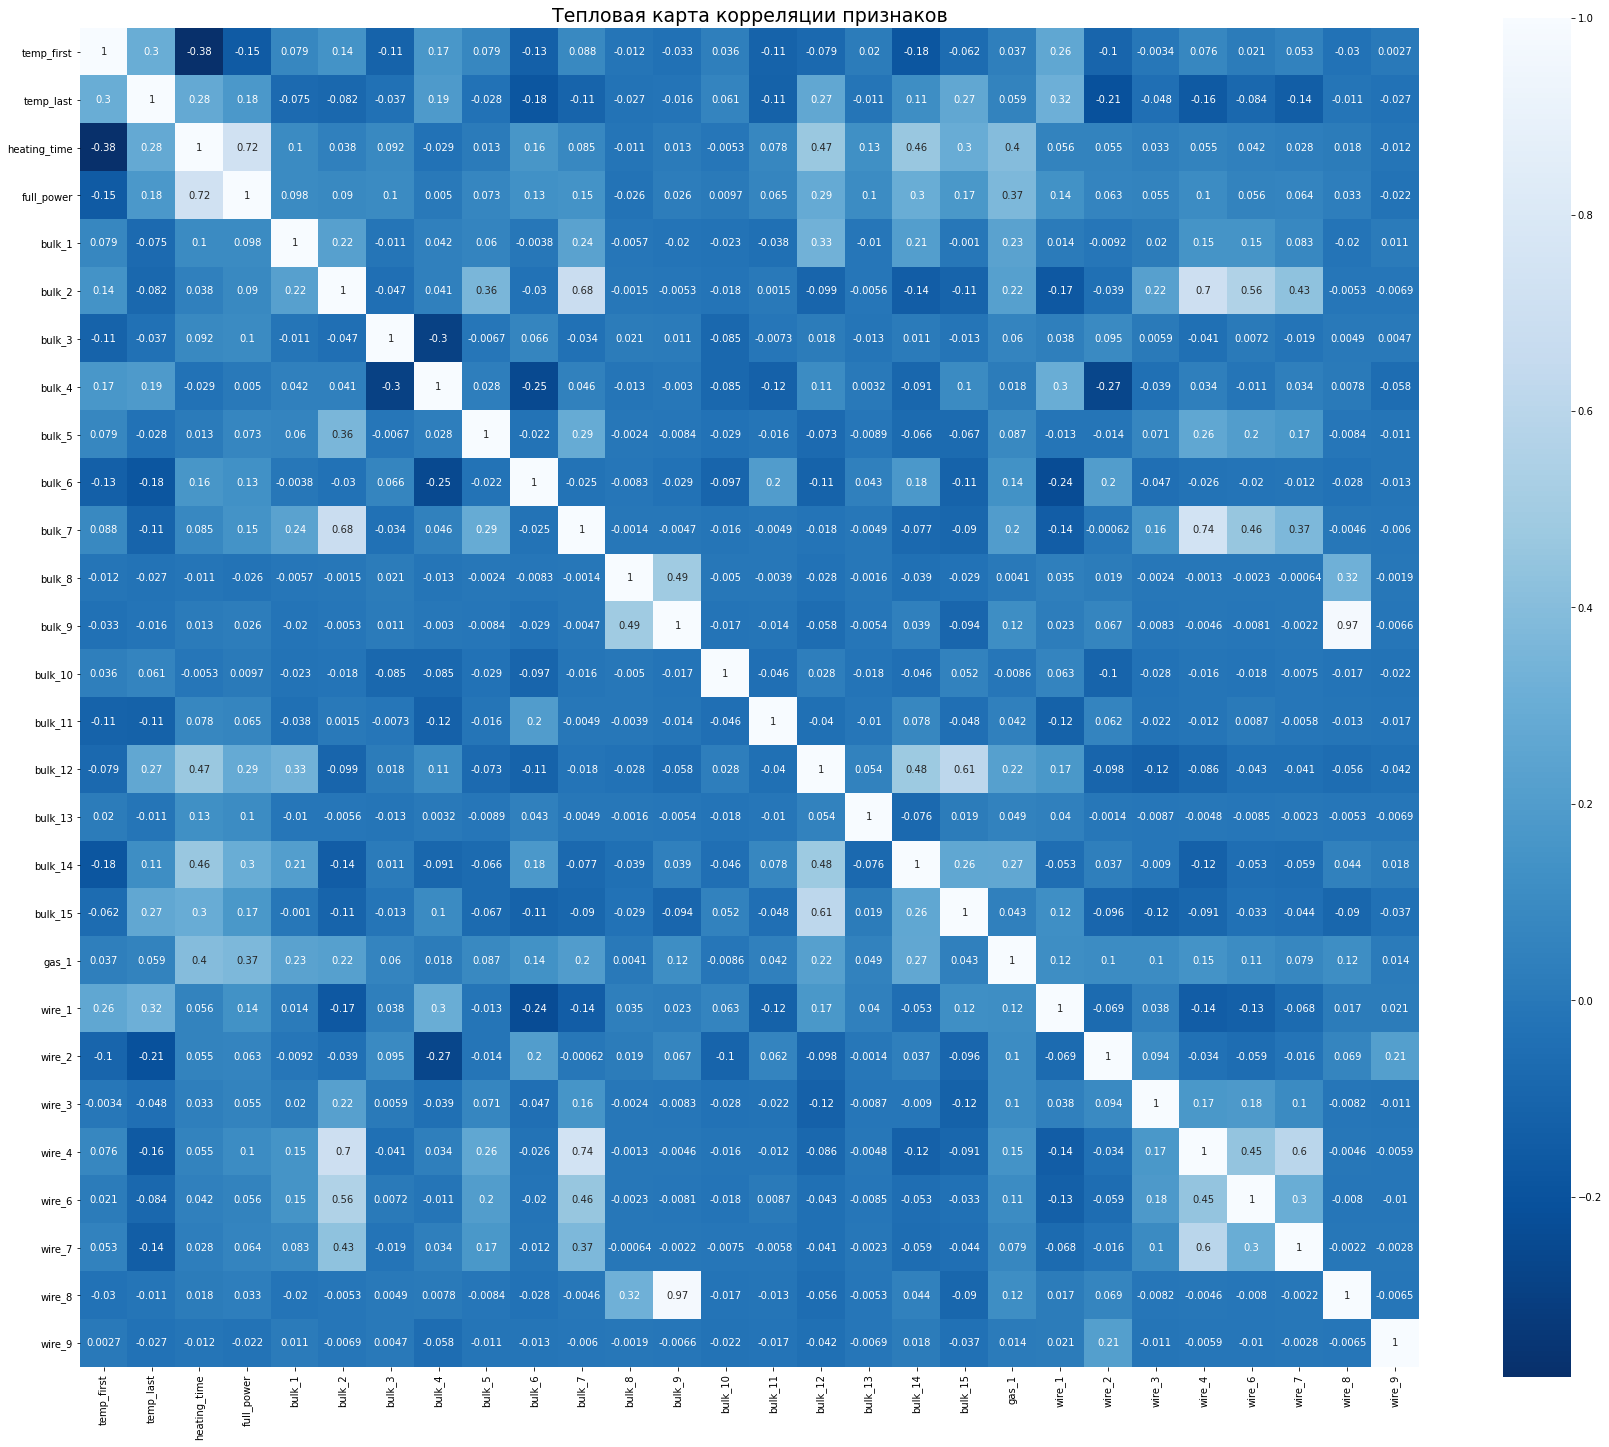

In [107]:
# посмотрим тепловую карту корреляций признаков после удаления лишнего

f, ax = plt.subplots(figsize=(30, 25))
corr = data.corr()
heatmap = sns.heatmap(corr,
                      xticklabels=True, 
                      yticklabels=True, 
                      annot=True, 
                      cmap='Blues_r', 
                      square=True);
plt.title('Тепловая карта корреляции признаков', fontsize=19)
plt.show();

Теперь по графику стало лучше видно зависимости:  
  
- bulk_9 и wire_8 имеют почти полную зависимость
- большая связь между bulk2 и bulk_7, wire_4, wire_6, wire_7; bulk_7 и wire_4, wire_6; wire_4 и wire_6 
- с целевым признаком temp_last связь у остальных маленькая  
  
Выведем корреляцию с последним измерением температуры отдельно

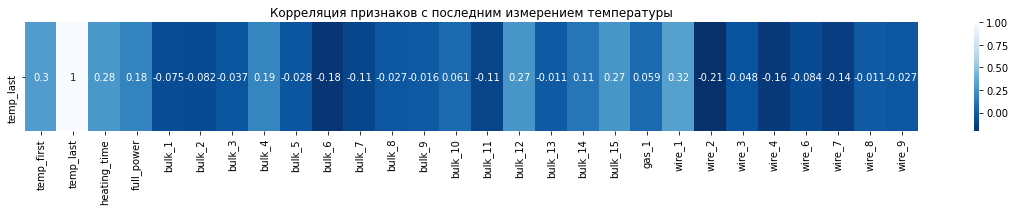

In [108]:
# выведем тепловую карту корреляции всех признаков с последним замером температуры

f,ax = plt.subplots(figsize=(20,2))

num = data.select_dtypes(exclude='object')
numcorr = num.corr()

sns.heatmap(numcorr.sort_values(by=['temp_last'], ascending=False).head(1), 
            cmap='Blues_r', 
            annot=True)
plt.title('Корреляция признаков с последним измерением температуры', fontsize=12)
plt.show();

Корреляция не большая, но все-таки прослеживается между последним замером температуры и первым замером, полной мощностью, сыпучими смесями 4, 12, 14, 15, проволочной 1.  
  
С признаками wire_8 и bulk_9 последний замер коррелирует в отрицательной и очень слабой зависимости. Выведем описание и решим, какой удалить для дальнейшей работы в линейных моделях. 

In [109]:
data[['bulk_9', 'wire_8']].describe()

,bulk_9,wire_8
count,2325.000000,2325.000000
mean,0.445591,0.311847
std,6.225965,4.406475
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,147.000000,102.762401


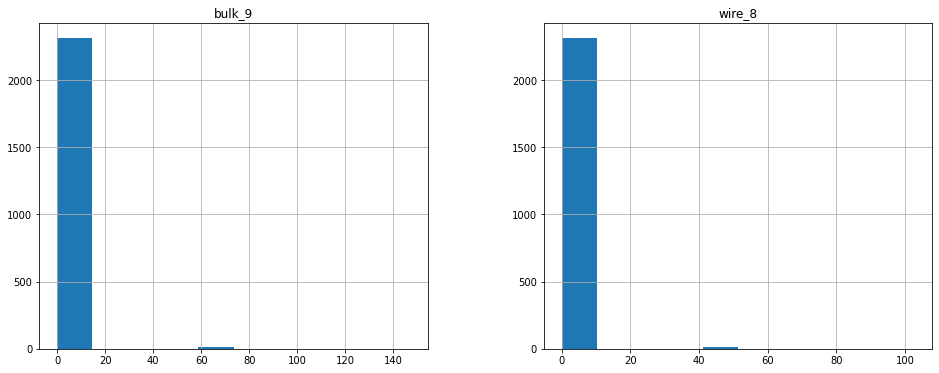

In [110]:
data[['bulk_9', 'wire_8']].hist(figsize=(16,6));

Удалим wire_8

In [111]:
# удалим проволочный материал 8

data = data.drop(['wire_8'], axis=1)

In [112]:
# проверим удаление 

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 27 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temp_first    2325 non-null   float64
 1   temp_last     2325 non-null   float64
 2   heating_time  2325 non-null   int64  
 3   full_power    2325 non-null   float64
 4   bulk_1        2325 non-null   float64
 5   bulk_2        2325 non-null   float64
 6   bulk_3        2325 non-null   float64
 7   bulk_4        2325 non-null   float64
 8   bulk_5        2325 non-null   float64
 9   bulk_6        2325 non-null   float64
 10  bulk_7        2325 non-null   float64
 11  bulk_8        2325 non-null   float64
 12  bulk_9        2325 non-null   float64
 13  bulk_10       2325 non-null   float64
 14  bulk_11       2325 non-null   float64
 15  bulk_12       2325 non-null   float64
 16  bulk_13       2325 non-null   float64
 17  bulk_14       2325 non-null   float64
 18  bulk_15       2325 non-null 

**Вывод:**    
  
На этом шаге мы построили тепловую карту корреляции признаков и:  
  
- удалили столбцы key, heating_time, active_power, reactive_power, wire_5, time_first, time_last, так как у них либо не было корреляции либо она была очень сильная между собой и full_power
- обнаружили, что большая связь между bulk2 и bulk_7, wire_4, wire_6, wire_7; bulk_7 и wire_4, wire_6; wire_4 и wire_6
- увидели, что bulk_9 и wire_8 имеют почти полную зависимость и проверив их оба, удалили wire_8,  чтобы их свзяь не мешала работе линейных моделей
- узнали, что корреляция не большая, но все-таки прослеживается между последним замером температуры и первым замером, полной мощностью, сыпучими смесями 4, 12, 14, 15, проволочной 1.  
  
Теперь можно переходить к разделению признаков и созданию выборок.

### 4.2 Разделение на признаки и целевой признак

In [113]:
# выделим признаки и целевой признак

features = data.drop(['temp_last'], axis=1)
target = data['temp_last']

In [114]:
# разобьем на обучающую и тестовую выборки

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=.25,
                                                                            random_state=RANDOM_STATE)

In [115]:
# проверим размеры выборок

for data in [features_train, features_test, target_train, target_test]:
    print(data.shape)

(1743, 26)
(582, 26)
(1743,)
(582,)


Данные разбиты на признаки и целевой признак, поделены на обучающую и тестовую выборку. Поскольку мы имеем числовые данные, то их следует стандартизировать. 

In [116]:
# стандартизируем численные признаки в обучающей выборке

scaler = StandardScaler()

scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

### 4.3 Вывод

На этом этом этапе мы проанализировали общую таблицу, создали тепловые карты и разделили данные на признаки и выборки. В процессе работы выводы были сделаны следующие:    
  
- большая связь между bulk2 и bulk_7, wire_4, wire_6, wire_7; bulk_7 и wire_4, wire_6; wire_4 и wire_6
- корреляция не большая, но все-таки прослеживается между последним замером температуры и первым замером, полной мощностью, сыпучими смесями 4, 12, 14, 15, проволочной 1.  
  
Данные готовы к работе с моделями машинного обучения.

## 5 Обучение моделей

На этом этапе мы обучим модели и выберем среди них лучшую. 

### 5.1 Линейная регрессия

In [117]:
%%time

# обучим модель линейной регрессии с кросс-валидацией

model_lin_reg = LinearRegression()

scores_lin_reg = cross_validate(model_lin_reg,
                                features_train, 
                                target_train, 
                                scoring=('neg_mean_absolute_error', 'r2'),
                                cv=7)

mae_lin_reg = np.mean(abs(scores_lin_reg['test_neg_mean_absolute_error']))
r2_lin_reg = np.mean(scores_lin_reg['test_r2'])

print()
print('MAE:', round(mae_lin_reg, 4))
print('R2:', round(r2_lin_reg,4))
print()


MAE: 6.3347
R2: 0.3932

CPU times: user 121 ms, sys: 181 ms, total: 303 ms
Wall time: 228 ms


Для линейной регрессии мы получили MAE = 6.3347, метрика R2 = 0.3932. Это означает, что модель в принципе справиться с новыми неизвестными данными, но средне. 

### 5.2 Модель случайный лес в регрессии

In [118]:
%%time

# обучим модель случайный лес

model_forest = RandomForestRegressor(random_state=RANDOM_STATE)

parameteres = {'n_estimators': [100, 300, 500], 
               'max_depth': [2, 4, 6], 
               'min_samples_split': [2, 5, 8]}

scoring=['neg_mean_absolute_error', 'r2']

grid_forest = GridSearchCV(model_forest, 
                           parameteres,                     
                           scoring=scoring, 
                           refit='neg_mean_absolute_error',
                           cv=7)

grid_forest.fit(features_train, target_train)

mae_forest = np.mean(abs(grid_forest.best_score_))
r2_forest = np.mean(abs(grid_forest.cv_results_['mean_test_r2']))

print()
print('MAE:', round(mae_forest, 4))
print('R2:', round(r2_forest, 4))
print('Параметры лучшей модели:', grid_forest.best_params_)
print()


MAE: 6.3114
R2: 0.3226
Параметры лучшей модели: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 100}

CPU times: user 3min 29s, sys: 1.13 s, total: 3min 30s
Wall time: 3min 30s


Для модели случайного леса в регрессии мы получили MAE = 6.3114 и R2 = 0.3226

### 5.3 CatBoost

In [119]:
%%time

# обучим модель CatBoostRegressor

model_cat = CatBoostRegressor(random_state=RANDOM_STATE)

parameteres = ({'learning_rate': [0.1, 0.3, 0.4],
                'verbose': [200],
                'n_estimators': [100]})

scoring=['neg_mean_absolute_error', 'r2']

grid = GridSearchCV(model_cat, 
                    parameteres,
                    scoring=scoring, 
                    refit='neg_mean_absolute_error',
                    cv=7)
    
grid.fit(features_train, target_train)

mae_cat = np.mean(abs(grid.best_score_))
r2_cat = np.mean(abs(grid.cv_results_['mean_test_r2']))

print()
print('MAE:', round(mae_cat, 4))
print('R2:', round(r2_cat, 4))
print('Параметры лучшей модели:', grid.best_params_)
print()

0:	learn: 10.9803094	total: 50.8ms	remaining: 5.03s
99:	learn: 6.6503941	total: 344ms	remaining: 0us
0:	learn: 11.0533544	total: 4.2ms	remaining: 416ms
99:	learn: 6.6532851	total: 329ms	remaining: 0us
0:	learn: 10.6976602	total: 3.58ms	remaining: 354ms
99:	learn: 6.6071027	total: 289ms	remaining: 0us
0:	learn: 10.9765775	total: 3.42ms	remaining: 339ms
99:	learn: 6.7252128	total: 303ms	remaining: 0us
0:	learn: 10.9269815	total: 3.17ms	remaining: 314ms
99:	learn: 6.7069740	total: 311ms	remaining: 0us
0:	learn: 10.9290143	total: 3.27ms	remaining: 324ms
99:	learn: 6.7150886	total: 287ms	remaining: 0us
0:	learn: 10.8698329	total: 4.38ms	remaining: 434ms
99:	learn: 6.5604914	total: 350ms	remaining: 0us
0:	learn: 10.4600401	total: 3.52ms	remaining: 348ms
99:	learn: 4.5402210	total: 305ms	remaining: 0us
0:	learn: 10.5892739	total: 3.32ms	remaining: 329ms
99:	learn: 4.5735653	total: 294ms	remaining: 0us
0:	learn: 10.1809910	total: 3.13ms	remaining: 310ms
99:	learn: 4.4023195	total: 302ms	remain

Для модели CatBoostRegressor мы получили MAE = 6.1499 и R2 = 0.4151  

### 5.4 Константная Dummy модель

In [120]:
%%time 

# проверим адекватность на константной модели 

model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
prediction_dummy = model_dummy.predict(features_test)

mae_dummy = mean_absolute_error(target_test, prediction_dummy)
r2_dummy = r2_score(target_test, prediction_dummy)

print()
print('MAE:', round(mae_dummy, 4))
print('R2:', round(r2_dummy, 4))
print()


MAE: 8.1894
R2: -0.0009

CPU times: user 4.04 ms, sys: 1e+03 ns, total: 4.04 ms
Wall time: 2.7 ms


Для Dummy модели мы получили MAE = 8.1894.  
Сразу проверили коэффециент детерминации, как дополнительную оценку для модели: R2 = -0.0009, что показывает - константная модель будет плохо работать с неизвестным набором данных.

### 5.5 Анализ моделей

In [121]:
# сделаем сводную таблицу результатов

index = ['Logistic Regression',
         'Random Forest Regressor',
         'CatBoost Regressor',
         'Dummy Regressor']

data = {'MAE':[round(mae_lin_reg, 4),
              round(mae_forest, 4),
              round(mae_cat, 4),
              round(mae_dummy, 4)],
        
        'R2':[round(r2_lin_reg, 4),
              round(r2_forest, 4),
              round(r2_cat, 4),
              round(r2_dummy, 4)],}

kpi_data = pd.DataFrame(data=data, index=index)
kpi_data

,MAE,R2
Logistic Regression,6.3347,0.3932
Random Forest Regressor,6.3114,0.3226
CatBoost Regressor,6.1499,0.4151
Dummy Regressor,8.1894,-0.0009


По таблице видно, что наилучший резлутат показывает модель CatBoostRegeressor с MAE = 6.1499 и с параметрами n_estimators = 100, learning_rate=0.1. R2 = 0.4151, что самый выскоий коэффициент детерменации среди обученных моделей. Это хороший результат в сравнении с константной моделью. Проверим модель на тестовых данных.

### 5.6 Тестирование лучшей модели

In [122]:
%%time

# проверим выбранную модель на тестовой выборке

model_cat = CatBoostRegressor(n_estimators = 100,  
                              learning_rate=0.1,
                              random_state=RANDOM_STATE)

model_cat.fit(features_train, target_train, verbose=50)
prediction_cat = model_cat.predict(features_test)

mae_cat_test = mean_absolute_error(target_test, prediction_cat)
r2_cat_test = r2_score(target_test, prediction_cat)

print()
print('MAE:', round(mae_cat_test, 4))
print('R2:', round(r2_cat_test, 4))
print()

0:	learn: 10.9249661	total: 5.65ms	remaining: 559ms
50:	learn: 7.5389147	total: 175ms	remaining: 168ms
99:	learn: 6.8164977	total: 331ms	remaining: 0us

MAE: 6.1772
R2: 0.4208

CPU times: user 343 ms, sys: 20.1 ms, total: 363 ms
Wall time: 1.77 s


На тестовых данных модель показала:  
  
MAE = 6.1772  
R2 = 0.4208  
  
Это очень хороший результат для метрики средней абсолютной ошибки. И приемлемый для коэффициента детерминации. Он показывает, что модель на новых неизвестных данных будут предсказывать хорошо. 

### 5.7 Анализ значимости признаков

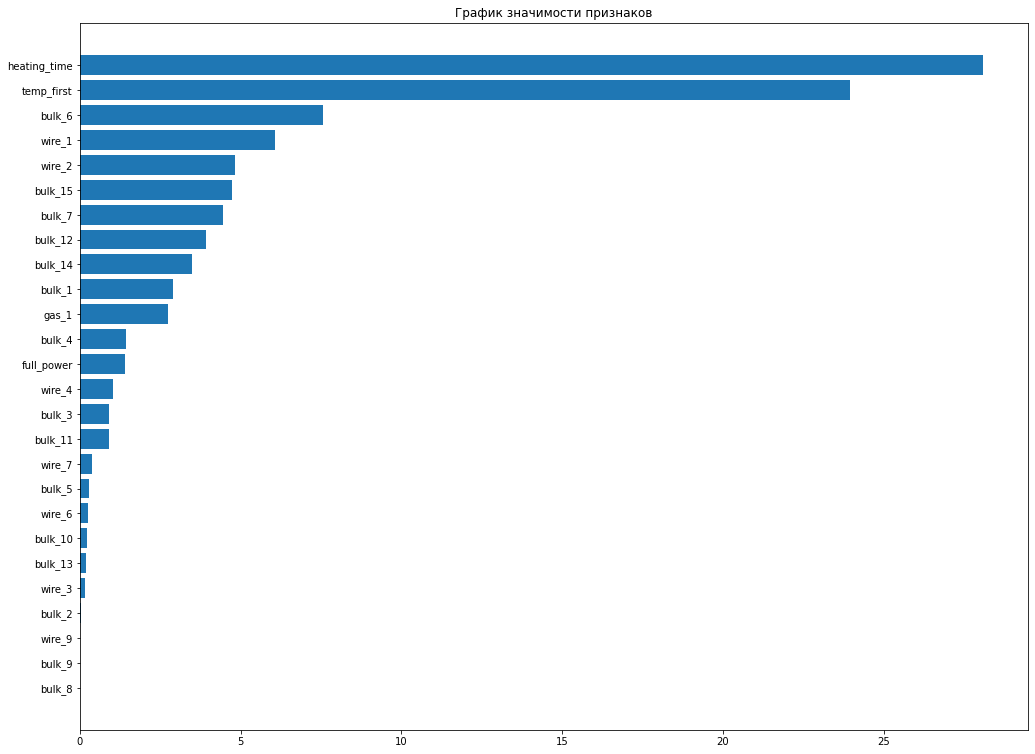

In [123]:
# построим график значимости признаков для модели CatBoostRegressor

feature_importance = model_cat.feature_importances_
sorted_indicies = np.argsort(feature_importance)

fig = plt.figure(figsize=(17, 13))
plt.barh(range(len(sorted_indicies)), feature_importance[sorted_indicies], align='center')
plt.yticks(range(len(sorted_indicies)), np.array(features.columns)[sorted_indicies])
plt.title('График значимости признаков');

Гррафик значимости признаков модели показывает:  
  
- наиболее значимые признаки: длительность нагрева, первый замер температуры, wire 1
- средне значимые признаки: wire 2, bulk 6, bulk 15, gas 1, полная мощность, bulk 14
- мало значимые признаки, но при этом явно использованные в модели: bulk 3, bulk 12, bulk 4, bulk 1, wire 6, bulk 11, wire 3, bulk 5, wire 4, bulk 10
- не значимые признаки: bulk 13, bulk 2, bulk 7, bulk 8, bulk 9, wire 7, wire 9 

  
Получается, что не все добавки в равной степени влияют на работу модели, а вот общая продолжительность нагрева, первый замер температуры и проволочная добавка wire 1 - влияют сильно. Можно так же отметить, что на тепловой карте корреляция признаков, ставших наиболее значимыми для модели, к финальному замеру температуру была самая высокая: heating time = 0.28, temp first = 0.3 и wire 1 = 0.32.

### 5.8 Вывод

Мы обучили 3 модели и получили следующие результаты:  
   
- Logistic Regression: MAE = 6.3347, R2 = 0.3932
- Random Forest Regressor: MAE = 6.3114, R2 = 0.3226
- CatBoost Regressor: MAE = 6.1499, R2 = 0.4208
- Dummy Regressor: MAE = 8.1894, R2 = -0.0009
  
Наилучший результат на обучение показала модель CatBoostRegressor с MAE = 6.1499, R2 = 0.4208 с параметрами n_estimators = 100, learning_rate=0.1.  
На тестовых данных модель показала MAE = 6.1772 и R2 = 0.4208, это хороший результат. С условием модель справилась.   
  
Анализ признаков значимости модели показал, что:  
  
- наиболее значимые признаки: длительность нагрева, первый замер температуры, wire 1
- средне значимые признаки: wire 2, bulk 6, bulk 15, gas 1, полная мощность, bulk 14
- мало значимые признаки, но при этом явно использованные в модели: bulk 3, bulk 12, bulk 4, bulk 1, wire 6, bulk 11, wire 3, bulk 5, wire 4, bulk 10
- не значимые признаки: bulk 13, bulk 2, bulk 7, bulk 8, bulk 9, wire 7, wire 9 
  
Из этого мы сделали вывод, что наилучшая модель CatBoostRegressor и наиболее значимые для нее признаки общая продолжительность нагрева, первый замер температуры и проволочная добавка wire_1.

## 6 Итоговый вывод

Нам нужно было построить модель, которая предскажет температуру стали для металлургического комбината ООО «Так закаляем сталь». Температура стали напрямую влияет на потребление электроэнергии на этапе обработки стали и вычисления необходимы, чтобы оптимизировать производственные расходы. Показателями успешности модели по задаче у нас была метрика MAE не ниже 6.8 на тестовых данных. Дополнительная метрика R2.  
  
В ходе работы мы:  
  
1. **Провели исследовательский анализ данных:**  

   На данном этапе мы рассмотрели все предоставленные датасеты и сделали по ним выводы, что:  
     
   - на предорбработке данных нужно будет поправить наименования, заполнить пропуски, удалить выбросы в реактивной мощности, а также удалить все партии с 2500, так как у них нет целевого замера - финальной температуры, и затем объединить данные в единую таблицу  
   - для объединения в таблицу нужно будет обработать значения в таблице data_temp, чтобы остались только начальная температура и конечная для каждого уникального ключа, а в таблице data_arc найти значение полной мощности и посмотреть при анализе признаков стоит ли оставить только его   
   - ключей везде разное количество, то нужно будет действовать по принципу внутреннего объединения исходя из наличия значений температуры нагрева, то есть присоединять будем к таблице data_temp
    

2. **Предобработали данные:**  
    
   На этом этапе мы сделали необходимые корректировки:  
     
   - в data_arc: исправили наименования столбцов, удалили отрицательное значение (выброс) в реактивной мощности, убрали данные для партий с 2500, так как в них не было замеров, сформировали новый датасет с информацией о длительности нагрева, активной и реактивной мощностях, полной мощности
   - в data_bulk: удалили данные о партиях начиная с 2500, переименовали столбцы и заполнили пропуски нулями
   - в data_gas: переименовали столбец с информацией о газе, удалили партии с 2500
   - в data_temp: удалили все партии с 2500, оставили только первые и последние замеры темературы, избавились от выбросов
   - в data_wire: удалили информацию о партиях с 2500, заполнили пропуски нулями и привели наименования столбцов к змеиному регистру 
   - объединили данные в единую таблицу для дальнейшей работы с признаками  
     

3. **Проанализировали признаки и подготовили их:**  
  
   На этом этом этапе мы проанализировали общую таблицу, создали тепловые карты и разделили данные на признаки и выборки. В процессе работы выводы были сделаны следующие:    
  
   - большая связь между bulk2 и bulk_7, wire_4, wire_6, wire_7; bulk_7 и wire_4, wire_6; wire_4 и wire_6
   - корреляция не большая, но все-таки прослеживается между последним замером температуры и первым замером, полной мощностью, сыпучими смесями 4, 12, 14, 15, проволочной 1.  
    
  
4. **Обучили модели:**  
  
   На этом шаге мы обучили 3 модели и получили следующие результаты:  
   
   - Logistic Regression: MAE = 6.3347, R2 = 0.3932
   - Random Forest Regressor: MAE = 6.3114, R2 = 0.3226
   - CatBoost Regressor: MAE = 6.1499, R2 = 0.4208
   - Dummy Regressor: MAE = 8.1894, R2 = -0.0009
  
   Наилучший результат на обучение показала модель CatBoostRegressor с MAE = 6.1499, R2 = 0.4208 с параметрами n_estimators = 100, learning_rate=0.1.  
   На тестовых данных модель показала MAE = 6.1772 и R2 = 0.4208, это хороший результат. С условием модель справилась.   
  
   Анализ признаков значимости модели показал, что:  
  
   - наиболее значимые признаки: длительность нагрева, первый замер температуры, wire 1 (можно так же отметить, что на тепловой карте корреляция признаков, ставших наиболее значимыми для модели, к финальному замеру температуру была самая высокая: heating time = 0.28, temp first = 0.3 и wire 1 = 0.32)
   - средне значимые признаки: wire 2, bulk 6, bulk 15, gas 1, полная мощность, bulk 14
   - мало значимые признаки, но при этом явно использованные в модели: bulk 3, bulk 12, bulk 4, bulk 1, wire 6, bulk 11, wire 3, bulk 5, wire 4, bulk 10
   - не значимые признаки: bulk 13, bulk 2, bulk 7, bulk 8, bulk 9, wire 7, wire 9 
  
   Из этого мы сделали вывод, что наилучшая модель CatBoostRegressor и наиболее значимые для нее признаки общая продолжительность нагрева, первый замер температуры и  проволочная добавка wire 1.
     
**ВЫВОД:** для предсказания температуры стали лучше всего использовать модель `CatBoostReegressor` с параметрами n_estimators = 100, learning_rate=0.1, обученную на предоставленных данных.

## 7 Отчет


Перед нами стояла задача построить модель, которая предскажет температуру стали для металлургического комбината ООО «Так закаляем сталь». Эти вычисления были необходимы предприятию, чтобы оптимизировать производственные расходы, а именно уменьшить расход потребления электроэнергии. Показателями успешности модели по задаче у нас была метрика MAE не ниже 6.8 на тестовых данных.   
  
Поставленная задача была выполнена. В ходе проекта мы ислледовали данные, предобработали их, подготовили признаки и обучили 3 модели. Затем выбрали самую удачную и проанализировали ее на тестовых данных, получив хороший результат MAE = 6.1772  
  
Подведем итог проделанной работе. 

### 7.1 Сравнение решения и плана работы над проектом

Первоначально план проекта была такой:  
  
1. Описание задачи 
2. Исследовательский анализ данных
3. Предобработка данных
4. Анализ и подготовка признаков
5. Обучение моделей
6. Итоговые выводы
7. Отчет  
  
В ходе работы мы выполнили все пункты, ничего не было пропущено, так же, как и добавлять к ним было нечего. Шаги были изначально сформированы верно.

### 7.2 Трудности проекта

Основными трудностями проекта стало большое количество пропусков в данных, отсутствие замеров после партии номер 2500 и низкая корреляция признаков с целевым признаком.  
  
Эти места мы решили следующим образом:  
   
- удалили данные после 2500 партий, что сократило выборку, но оставило нам достаточно материала для дальнейшей работы
- заполнили пропуски нулями, проконсультировавшись с заказчиком и получив утверждение на такой шаг
- низкая корреляция повлияла на метрику оценки модели - мы взяли дополнительную метрику R2, чтобы посмотреть насколько она влияет на модель, при этом стало понятно, что изначально выбор метрики MAE для оценки работы модели был верным и более точным в наших условиях.

### 7.3 Ключевые шаги решения

Вся проделанная работа была значимой и важной, при этом нужно отметить, что ключевыми шагами стали:  
  
- обработка данных из таблицы об электродах: здесь мы получили полное время нагревания смеси, которое в итоге сыграло важную роль для машинного обучение
- обработка таблицы замера температуры: здесь мы получили структуру под общую таблицу, удалив партии с пустыми замерами и оставив только первый и последний результат температур, что так же сыграло важную роль для последующей работы

### 7.4 Признаки и их обработка

После того, как мы обработали и объединили все данные в один датасет, нам было необходимо изучить признаки. Мы проанализировали общую таблицу, создали тепловые карты и разделили данные на признаки и выборки. В процессе работы выводы были сделаны следующие:

- большая связь между bulk2 и bulk_7, wire_4, wire_6, wire_7; bulk_7 и wire_4, wire_6; wire_4 и wire_6
- корреляция не большая, но все-таки прослеживается между последним замером температуры и первым замером, полной мощностью, сыпучими смесями 4, 12, 14, 15, проволочной 1
  
После выбора лучшей модели, мы ее протестировали и посмотрели на графике значимость признаков. Вот что вышло:  
  
   - наиболее значимые признаки: длительность нагрева, первый замер температуры, wire 1 (можно так же отметить, что на тепловой карте корреляция признаков, ставших наиболее значимыми для модели, к финальному замеру температуру была самая высокая: heating time = 0.28, temp first = 0.3 и wire 1 = 0.32)
   - средне значимые признаки: wire 2, bulk 6, bulk 15, gas 1, полная мощность, bulk 14
   - мало значимые признаки, но при этом явно использованные в модели: bulk 3, bulk 12, bulk 4, bulk 1, wire 6, bulk 11, wire 3, bulk 5, wire 4, bulk 10
   - не значимые признаки: bulk 13, bulk 2, bulk 7, bulk 8, bulk 9, wire 7, wire 9   
     
Большинство из признаков были изначально в исходных данных, но некоторые были получены в ходе предобработки и затем подготовки признаков:  
  
- heating_time - длительность нагрева - эти данные были получены из таблицы data_arc через расчет разница конца и начала времени нагрева и перевода получившегося времени в секунды
- temp_first - первый замер температуры для партии - были получены из таблицы data_temp путем вывода только первых и последних замеров температуры для каждой партии
- temp_last - последний замер температуры - был получен так же как и temp_first и стал ключевым признаком для обучения моделей
- full_power - полная мощность - эти данные мы получили из аблицы data_arc через расчет квадратного корня из суммы квадратов активной и реактивной мощностей


### 7.5 Итоговая модель

Итоговой моделью для предсказания температуры стали была выбрана модель `CatBoostReegressor` с параметрами n_estimators = 100, learning_rate = 0.1, random_state = 220523 и метрикой MAE = 6.1772, что полностью соответсвует поставленной задаче.